In [2]:
import torch
import os 
from pathlib import Path

# El alto y ancho de las imágenes debe ser divisible por 16 para que concidan las dimensiones de las capas 
# convolucionales y convolucionales transpuestas.
path = Path('./')
imgs = [path/'img'/i for i in os.listdir(path/'img')]
masks = [path/'mask'/i for i in os.listdir(path/'mask')]

len(imgs), len(masks)

(1, 1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i=0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
img = np.load(imgs[i])
mask = np.load(masks[i])
ax1.imshow(torch.from_numpy(img).permute(1,2,0).numpy())
ax2.imshow(mask)
plt.show()
print(imgs[i])
print(mask.shape)
print(len(masks))
print(len(imgs)) 
    

In [3]:
import numpy as np
import torchvision 

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=10):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    #img = torch.tensor(img).unsqueeze(0) Para el caso donde se trabaje con un solo canal
    img = torch.tensor(img) # Para el caso donde se trabaje con tres canales 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [4]:
dataset = {
    'train': Dataset(imgs[:-50], masks[:-50]),
    'test': Dataset(imgs[-50:], masks[-50:])
}

len(dataset['train']), len(dataset['test'])

(260, 50)

In [5]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=10, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([10, 3, 480, 640]), torch.Size([10, 10, 480, 640]))

In [7]:
import torchvision
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=10, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        #self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        #x_in = torch.tensor(x.clone())
        x_in = x.clone().detach() #or the same with .requires_grad_(True),
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        #x = self.encoder.maxpool(x)
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [8]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [9]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=0.001, wd=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [17]:
import torchvision
import torch.nn.functional as F

class out_conv(torch.nn.Module):
    def __init__(self, ci, co):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, kernel_size=16, stride=8, padding=4)
        self.final = torch.nn.Conv2d(co*2, co, kernel_size=7, stride=1, padding=3)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=7, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        #self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        self.encoder = torch.nn.Sequential(*list(self.encoder.children())[:-4])
        self.out = out_conv(128, n_classes)

    def forward(self, x):
        capas = list(self.encoder.children())
        x_in = x.clone().detach()
        x = capas[0](x)
        x = capas[1](x)
        x = capas[2](x)
        x = capas[3](x)
        x = capas[4](x)
        x = capas[5](x)
        x = self.out(x, x_in)
        return x

In [72]:
model = UNetResnet()
#print(model)
hist = fit(model, dataloader, epochs=100)

test_loss 0.51788 test_iou 0.46158: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]



Epoch 1/100 loss 0.52956 iou 0.35824 test_loss 0.51788 test_iou 0.46158


test_loss 0.26062 test_iou 0.71492: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]



Epoch 2/100 loss 0.32427 iou 0.67161 test_loss 0.26062 test_iou 0.71492


test_loss 0.17576 test_iou 0.74027: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 3/100 loss 0.21286 iou 0.73059 test_loss 0.17576 test_iou 0.74027


test_loss 0.12757 test_iou 0.74777: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 4/100 loss 0.15756 iou 0.73304 test_loss 0.12757 test_iou 0.74777


test_loss 0.12941 test_iou 0.73932: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]



Epoch 5/100 loss 0.12432 iou 0.74328 test_loss 0.12941 test_iou 0.73932


test_loss 0.09146 test_iou 0.76236: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 6/100 loss 0.10557 iou 0.75274 test_loss 0.09146 test_iou 0.76236


test_loss 0.10397 test_iou 0.74942: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]



Epoch 7/100 loss 0.09518 iou 0.75403 test_loss 0.10397 test_iou 0.74942


test_loss 0.07267 test_iou 0.76950: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]



Epoch 8/100 loss 0.08531 iou 0.75666 test_loss 0.07267 test_iou 0.76950


test_loss 0.07250 test_iou 0.76635: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]



Epoch 9/100 loss 0.07465 iou 0.76584 test_loss 0.07250 test_iou 0.76635


test_loss 0.05752 test_iou 0.78031: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 10/100 loss 0.07150 iou 0.75165 test_loss 0.05752 test_iou 0.78031


test_loss 0.05266 test_iou 0.74084: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



Epoch 11/100 loss 0.06406 iou 0.75131 test_loss 0.05266 test_iou 0.74084


test_loss 0.07392 test_iou 0.74838: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 12/100 loss 0.05831 iou 0.71761 test_loss 0.07392 test_iou 0.74838


test_loss 0.09357 test_iou 0.57820: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



Epoch 13/100 loss 0.05883 iou 0.71393 test_loss 0.09357 test_iou 0.57820


test_loss 0.05380 test_iou 0.69902: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



Epoch 14/100 loss 0.05479 iou 0.70966 test_loss 0.05380 test_iou 0.69902


test_loss 0.05593 test_iou 0.70737: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



Epoch 15/100 loss 0.05110 iou 0.71298 test_loss 0.05593 test_iou 0.70737


test_loss 0.06592 test_iou 0.73072: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 16/100 loss 0.05198 iou 0.70779 test_loss 0.06592 test_iou 0.73072


test_loss 0.04170 test_iou 0.77841: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



Epoch 17/100 loss 0.04440 iou 0.74129 test_loss 0.04170 test_iou 0.77841


test_loss 0.04503 test_iou 0.70241: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



Epoch 18/100 loss 0.03930 iou 0.75420 test_loss 0.04503 test_iou 0.70241


test_loss 0.04603 test_iou 0.78073: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 19/100 loss 0.03732 iou 0.76622 test_loss 0.04603 test_iou 0.78073


test_loss 0.04167 test_iou 0.76954: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 20/100 loss 0.03558 iou 0.77315 test_loss 0.04167 test_iou 0.76954


test_loss 0.04000 test_iou 0.79377: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 21/100 loss 0.03619 iou 0.76573 test_loss 0.04000 test_iou 0.79377


test_loss 0.04828 test_iou 0.78640: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 22/100 loss 0.03289 iou 0.77913 test_loss 0.04828 test_iou 0.78640


test_loss 0.04350 test_iou 0.70239: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 23/100 loss 0.03362 iou 0.76777 test_loss 0.04350 test_iou 0.70239


test_loss 0.04317 test_iou 0.78999: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]



Epoch 24/100 loss 0.03141 iou 0.77592 test_loss 0.04317 test_iou 0.78999


test_loss 0.03950 test_iou 0.78464: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 25/100 loss 0.02790 iou 0.79918 test_loss 0.03950 test_iou 0.78464


test_loss 0.04036 test_iou 0.78027: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 26/100 loss 0.02668 iou 0.80257 test_loss 0.04036 test_iou 0.78027


test_loss 0.03697 test_iou 0.80942: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]



Epoch 27/100 loss 0.02554 iou 0.80860 test_loss 0.03697 test_iou 0.80942


test_loss 0.04226 test_iou 0.71306: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]



Epoch 28/100 loss 0.02435 iou 0.81879 test_loss 0.04226 test_iou 0.71306


test_loss 0.03992 test_iou 0.76346: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]



Epoch 29/100 loss 0.02327 iou 0.82457 test_loss 0.03992 test_iou 0.76346


test_loss 0.03792 test_iou 0.80006: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 30/100 loss 0.02299 iou 0.82212 test_loss 0.03792 test_iou 0.80006


test_loss 0.03864 test_iou 0.78799: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 31/100 loss 0.02040 iou 0.83754 test_loss 0.03864 test_iou 0.78799


test_loss 0.03934 test_iou 0.79731: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]



Epoch 32/100 loss 0.01949 iou 0.85182 test_loss 0.03934 test_iou 0.79731


test_loss 0.04316 test_iou 0.70728: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 33/100 loss 0.01916 iou 0.84474 test_loss 0.04316 test_iou 0.70728


test_loss 0.04348 test_iou 0.79961: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]



Epoch 34/100 loss 0.01988 iou 0.82590 test_loss 0.04348 test_iou 0.79961


test_loss 0.03944 test_iou 0.79430: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 35/100 loss 0.02100 iou 0.83519 test_loss 0.03944 test_iou 0.79430


test_loss 0.04715 test_iou 0.78134: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 36/100 loss 0.01850 iou 0.85451 test_loss 0.04715 test_iou 0.78134


test_loss 0.04899 test_iou 0.78674: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 37/100 loss 0.02039 iou 0.84458 test_loss 0.04899 test_iou 0.78674


test_loss 0.04279 test_iou 0.81522: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 38/100 loss 0.01997 iou 0.84198 test_loss 0.04279 test_iou 0.81522


test_loss 0.04027 test_iou 0.83155: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 39/100 loss 0.01839 iou 0.85482 test_loss 0.04027 test_iou 0.83155


test_loss 0.04332 test_iou 0.80471: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 40/100 loss 0.01728 iou 0.84995 test_loss 0.04332 test_iou 0.80471


test_loss 0.04321 test_iou 0.81926: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 41/100 loss 0.01589 iou 0.87206 test_loss 0.04321 test_iou 0.81926


test_loss 0.04681 test_iou 0.79868: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 42/100 loss 0.01627 iou 0.85894 test_loss 0.04681 test_iou 0.79868


test_loss 0.03984 test_iou 0.82380: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 43/100 loss 0.01485 iou 0.87075 test_loss 0.03984 test_iou 0.82380


test_loss 0.04176 test_iou 0.82182: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 44/100 loss 0.01324 iou 0.87760 test_loss 0.04176 test_iou 0.82182


test_loss 0.04060 test_iou 0.84274: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 45/100 loss 0.01292 iou 0.88239 test_loss 0.04060 test_iou 0.84274


test_loss 0.04072 test_iou 0.83307: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 46/100 loss 0.01220 iou 0.87777 test_loss 0.04072 test_iou 0.83307


test_loss 0.04068 test_iou 0.82298: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]



Epoch 47/100 loss 0.01159 iou 0.87914 test_loss 0.04068 test_iou 0.82298


test_loss 0.04288 test_iou 0.83800: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 48/100 loss 0.01098 iou 0.89862 test_loss 0.04288 test_iou 0.83800


test_loss 0.04770 test_iou 0.80391: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 49/100 loss 0.01137 iou 0.87922 test_loss 0.04770 test_iou 0.80391


test_loss 0.12634 test_iou 0.56581: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]



Epoch 50/100 loss 0.03907 iou 0.74021 test_loss 0.12634 test_iou 0.56581


test_loss 0.06841 test_iou 0.71948: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 51/100 loss 0.03288 iou 0.78240 test_loss 0.06841 test_iou 0.71948


test_loss 0.04630 test_iou 0.79683: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 52/100 loss 0.02209 iou 0.81631 test_loss 0.04630 test_iou 0.79683


test_loss 0.04024 test_iou 0.81283: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 53/100 loss 0.01679 iou 0.86218 test_loss 0.04024 test_iou 0.81283


test_loss 0.03959 test_iou 0.83098: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]



Epoch 54/100 loss 0.01423 iou 0.86866 test_loss 0.03959 test_iou 0.83098


test_loss 0.04033 test_iou 0.83581: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]



Epoch 55/100 loss 0.01268 iou 0.87014 test_loss 0.04033 test_iou 0.83581


test_loss 0.04208 test_iou 0.83608: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]



Epoch 56/100 loss 0.01145 iou 0.89262 test_loss 0.04208 test_iou 0.83608


test_loss 0.03960 test_iou 0.81583: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]



Epoch 57/100 loss 0.01068 iou 0.88819 test_loss 0.03960 test_iou 0.81583


test_loss 0.04201 test_iou 0.82294: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]



Epoch 58/100 loss 0.01013 iou 0.89185 test_loss 0.04201 test_iou 0.82294


test_loss 0.04265 test_iou 0.81144: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]



Epoch 59/100 loss 0.00963 iou 0.89135 test_loss 0.04265 test_iou 0.81144


test_loss 0.04278 test_iou 0.81761: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]



Epoch 60/100 loss 0.00982 iou 0.89225 test_loss 0.04278 test_iou 0.81761


test_loss 0.04400 test_iou 0.82164: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]



Epoch 61/100 loss 0.00940 iou 0.88788 test_loss 0.04400 test_iou 0.82164


test_loss 0.04224 test_iou 0.82513: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 62/100 loss 0.00895 iou 0.90229 test_loss 0.04224 test_iou 0.82513


test_loss 0.04248 test_iou 0.81720: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 63/100 loss 0.00887 iou 0.89406 test_loss 0.04248 test_iou 0.81720


test_loss 0.04524 test_iou 0.82317: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 64/100 loss 0.00842 iou 0.88872 test_loss 0.04524 test_iou 0.82317


test_loss 0.04696 test_iou 0.72565: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 65/100 loss 0.01008 iou 0.88743 test_loss 0.04696 test_iou 0.72565


test_loss 0.04471 test_iou 0.79249: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 66/100 loss 0.01165 iou 0.87215 test_loss 0.04471 test_iou 0.79249


test_loss 0.05080 test_iou 0.77461: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 67/100 loss 0.00969 iou 0.88707 test_loss 0.05080 test_iou 0.77461


test_loss 0.04268 test_iou 0.81681: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 68/100 loss 0.00970 iou 0.88263 test_loss 0.04268 test_iou 0.81681


test_loss 0.04380 test_iou 0.80863: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 69/100 loss 0.00828 iou 0.90441 test_loss 0.04380 test_iou 0.80863


test_loss 0.04536 test_iou 0.82978: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 70/100 loss 0.00794 iou 0.90127 test_loss 0.04536 test_iou 0.82978


test_loss 0.04600 test_iou 0.81451: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 71/100 loss 0.00747 iou 0.89912 test_loss 0.04600 test_iou 0.81451


test_loss 0.04519 test_iou 0.82967: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 72/100 loss 0.00706 iou 0.90899 test_loss 0.04519 test_iou 0.82967


test_loss 0.04689 test_iou 0.82389: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 73/100 loss 0.00662 iou 0.90736 test_loss 0.04689 test_iou 0.82389


test_loss 0.04684 test_iou 0.83183: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 74/100 loss 0.00631 iou 0.90957 test_loss 0.04684 test_iou 0.83183


test_loss 0.04794 test_iou 0.80201: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



Epoch 75/100 loss 0.00622 iou 0.91263 test_loss 0.04794 test_iou 0.80201


test_loss 0.04745 test_iou 0.79992: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]



Epoch 76/100 loss 0.00619 iou 0.91112 test_loss 0.04745 test_iou 0.79992


test_loss 0.04824 test_iou 0.77020: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]



Epoch 77/100 loss 0.00620 iou 0.91100 test_loss 0.04824 test_iou 0.77020


test_loss 0.04777 test_iou 0.79976: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]



Epoch 78/100 loss 0.00631 iou 0.90794 test_loss 0.04777 test_iou 0.79976


test_loss 0.04790 test_iou 0.81629: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]



Epoch 79/100 loss 0.00625 iou 0.90544 test_loss 0.04790 test_iou 0.81629


test_loss 0.04929 test_iou 0.80082: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]



Epoch 80/100 loss 0.00573 iou 0.91444 test_loss 0.04929 test_iou 0.80082


test_loss 0.04871 test_iou 0.78557: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]



Epoch 81/100 loss 0.00563 iou 0.91552 test_loss 0.04871 test_iou 0.78557


test_loss 0.04919 test_iou 0.79226: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]



Epoch 82/100 loss 0.00569 iou 0.91479 test_loss 0.04919 test_iou 0.79226


test_loss 0.04884 test_iou 0.79147: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]



Epoch 83/100 loss 0.00561 iou 0.91640 test_loss 0.04884 test_iou 0.79147


test_loss 0.04772 test_iou 0.77433: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 84/100 loss 0.00539 iou 0.92036 test_loss 0.04772 test_iou 0.77433


test_loss 0.04762 test_iou 0.78159: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]



Epoch 85/100 loss 0.00537 iou 0.91653 test_loss 0.04762 test_iou 0.78159


test_loss 0.04941 test_iou 0.76769: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 86/100 loss 0.00530 iou 0.91425 test_loss 0.04941 test_iou 0.76769


test_loss 0.04876 test_iou 0.79705: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 87/100 loss 0.00512 iou 0.91693 test_loss 0.04876 test_iou 0.79705


test_loss 0.04890 test_iou 0.77083: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 88/100 loss 0.00516 iou 0.91814 test_loss 0.04890 test_iou 0.77083


test_loss 0.04895 test_iou 0.78147: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]



Epoch 89/100 loss 0.00601 iou 0.90715 test_loss 0.04895 test_iou 0.78147


test_loss 0.04753 test_iou 0.75099: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]



Epoch 90/100 loss 0.00608 iou 0.91211 test_loss 0.04753 test_iou 0.75099


test_loss 0.04643 test_iou 0.75779: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]



Epoch 91/100 loss 0.00574 iou 0.91179 test_loss 0.04643 test_iou 0.75779


test_loss 0.05007 test_iou 0.80861: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 92/100 loss 0.00560 iou 0.90408 test_loss 0.05007 test_iou 0.80861


test_loss 0.05167 test_iou 0.74259: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



Epoch 93/100 loss 0.00660 iou 0.89157 test_loss 0.05167 test_iou 0.74259


test_loss 0.04806 test_iou 0.72751: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 94/100 loss 0.00684 iou 0.87822 test_loss 0.04806 test_iou 0.72751


test_loss 0.05056 test_iou 0.79266: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Epoch 95/100 loss 0.00616 iou 0.90159 test_loss 0.05056 test_iou 0.79266


test_loss 0.04599 test_iou 0.78662: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 96/100 loss 0.00582 iou 0.90812 test_loss 0.04599 test_iou 0.78662


test_loss 0.05132 test_iou 0.81485: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]



Epoch 97/100 loss 0.00516 iou 0.92321 test_loss 0.05132 test_iou 0.81485


test_loss 0.04869 test_iou 0.81471: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Epoch 98/100 loss 0.00467 iou 0.93083 test_loss 0.04869 test_iou 0.81471


test_loss 0.05083 test_iou 0.80862: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]



Epoch 99/100 loss 0.00460 iou 0.92871 test_loss 0.05083 test_iou 0.80862


test_loss 0.05078 test_iou 0.76159: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 100/100 loss 0.00468 iou 0.92331 test_loss 0.05078 test_iou 0.76159


Epoch 10/10 loss 0.06984 iou 0.76055 test_loss 0.05955 test_iou 0.77610 --  
Epoch 30/30 loss 0.02229 iou 0.80324 test_loss 0.04631 test_iou 0.79112 --  
Epoch 100/100 loss 0.00468 iou 0.92331 test_loss 0.05078 test_iou 0.76159  

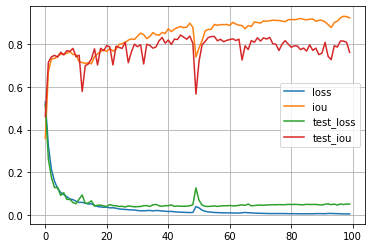

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [74]:
ix=0

0.012331008911132812


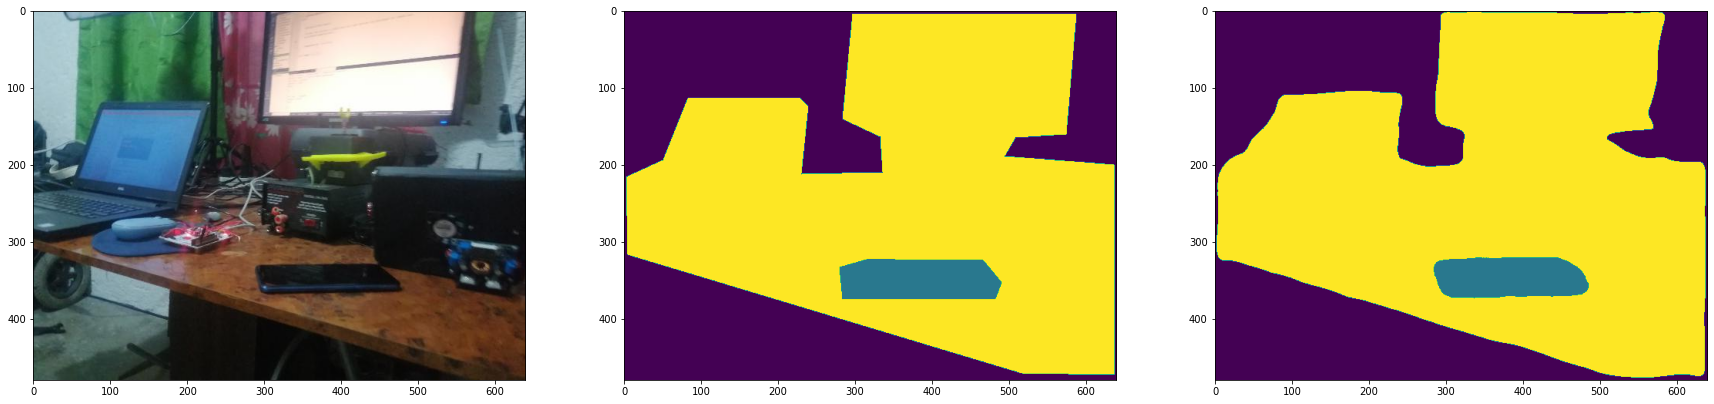

In [112]:
import random
import time

ix=15
model.eval()
with torch.no_grad():
    #ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    inicio=time.time()
    output = model(img.unsqueeze(0).to(device))[0]
    termino=time.time()
    print(termino-inicio)
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()


In [33]:
#Para cargar una red ya entrenada
import torch
torch.save(model,'modelo.pt')
#model = torch.load('model.pt',map_location='cpu')

In [ ]:
# Para predecir con el modelo entrenado y mostrar como imagen la mascara generada
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
imagen=torchvision.io.read_image('./imagen.jpg')
imagen=imagen.float()/255
model.eval()
with torch.no_grad():
    output = model(imagen.unsqueeze(0).to(device))[0]
    mascara_pred = torch.argmax(output, axis=0)
np.save('./mascara',mascara_pred.numpy())
print(imagen.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(imagen.squeeze(0).permute(1,2,0))
ax2.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()

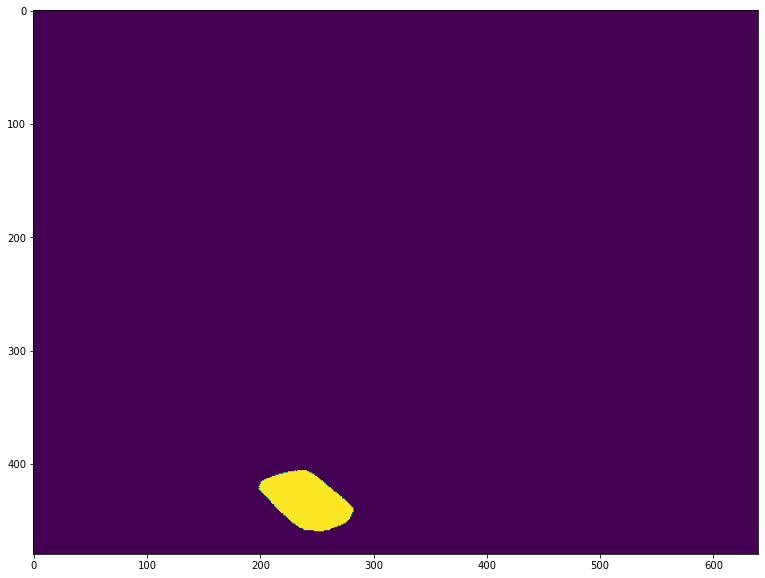

In [28]:
# Para abrir como imagen la mascara.npy generada en la Raspberry
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
mascara_pred=np.load('./mascara.npy')
mascara_pred=torch.tensor(mascara_pred)
fig, (ax1) = plt.subplots(1, 1, figsize=(30,10))
ax1.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()